In [1]:
import os, sys
from os.path import dirname
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from unittest.mock import MagicMock, patch
from performance_data.data_table import PhaseData, DataTable
from performance_data.data_model import PhaseGenerator, TierModel, DataModel, load_and_predict
from performance_data.data_model import DeepNNModel
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from functools import partial
import plotly.graph_objs as go
import plotly.subplots as sp
import plotly.io as pio
import loguru
from pprint import pprint
loguru.logger.remove()
loguru.logger.add(sys.stderr, level="INFO")

1

In [2]:
def plot_fit(model):
    """
    Plots the fit of the model on the training data.
    """
    # Make predictions on the training data
    y_test_pred = model.predict(model.X_test)

    # Plot the fit of the model on the training data
    plt.scatter(model.y_test, y_test_pred, color='blue')
    plt.ylabel("Predictions")
    plt.xlabel("True Values")
    plt.title("Fit of the Model on the Training Data")
    plt.show()

In [ ]:
save_dir = "/home_nfs/mimounis/iosea-wp3-recommandation-system/performance_data/performance_data/notebooks"
# DecisionTreeRegressor
# for model in [MLPRegressor, LinearRegression, Ridge, Lasso, ElasticNet, 
#               RandomForestRegressor, GradientBoostingRegressor, SVR]:

for model in [DecisionTreeRegressor]:

#dmodel = DeepNNModel#(depth=3, width=32, input_dim=14)
#dmodel = partial(DeepNNModel, depth=15, width=32)

  
    model_1 = TierModel(regressor=model())
    model_2 = TierModel(regressor=model())
    models_list = [model_1, model_2]
    data_model = DataModel(models=models_list)
    trained_models = data_model.train_model(save_dir=save_dir)
    for col in data_model.y.columns:
        X_test = data_model.X_test
        y_test = data_model.y_test[col]
        y_test_pred = data_model.models[col].predict(data_model.X_test)
        y_train_pred = data_model.models[col].predict(data_model.X_train)
        train_score = data_model.models[col].score(data_model.X_train, data_model.y_train[col])
        score = data_model.models[col].score(X_test, y_test)
        
        # plt.scatter(y_test, y_test_pred, color='blue')
        # plt.scatter(data_model.y_train[col], y_train_pred, color='red')
        # plt.ylabel("Predictions")
        # plt.xlabel("True Values")
        # plt.title(f"Fit of {data_model.model_name(col)} - score={score:.3} / train_score={train_score:.3}")
        # plt.rcParams["figure.figsize"] = (7,7)
        # plt.grid()
        # plt.show()
        # Create a scatter plot for the test data
        marker_opacity = 0.5
        marker_size = 10

        # Define the scaling factors for the x-axis and y-axis
        x_scale_factor = 1e-6
        y_scale_factor = 1e-6

        # Apply the scaling factors to the data
        scaled_y_test = y_test * x_scale_factor
        scaled_y_train = data_model.y_train[col] * x_scale_factor
        scaled_y_test_pred = y_test_pred * y_scale_factor
        scaled_y_train_pred = y_train_pred * y_scale_factor

        scatter_test = go.Scatter(
            x=scaled_y_test,
            y=scaled_y_test_pred,
            mode='markers',
            marker=dict(color='blue', size=marker_size),
            name='Test Data'
        )

        scatter_train = go.Scatter(
            x=scaled_y_train,
            y=scaled_y_train_pred,
            mode='markers',
            marker=dict(color='gray', opacity=marker_opacity, size=marker_size),
            name='Train Data'
        )

        # Determine the scaled axis extents
        x_data = np.concatenate((scaled_y_test, scaled_y_train))
        y_data = np.concatenate((scaled_y_test_pred, scaled_y_train_pred))
        x_min, x_max = x_data.min(), x_data.max()
        y_min, y_max = y_data.min(), y_data.max()

        # Add the y=x line
        line_y_equals_x = go.Scatter(
            x=[x_min, x_max],
            y=[x_min * y_scale_factor / x_scale_factor, x_max * y_scale_factor / x_scale_factor],
            mode='lines',
            line=dict(color='black', dash='dash'),
            name='y=x'
        )
        layout = go.Layout(
            title=f"Fit of {data_model.model_name(col)} <br> R²(test)={score:.3} | R²(train)={train_score:.3}",
            xaxis=dict(title="Measured BW Values", gridcolor='rgb(219, 219, 219)', range=[x_min, x_max]),
            yaxis=dict(title="Predicted BW Values", gridcolor='rgb(219, 219, 219)', range=[y_min, y_max]),
            plot_bgcolor='rgb(255, 255, 255)',
            width=600,
            height=600,
            legend=dict(x=1, y=1),
            font=dict(size=12),
            shapes=[
                # Add border shapes
                dict(type='rect', xref='x', yref='y', x0=x_min, x1=x_max, y0=y_min, y1=y_max, line=dict(color='black')),
                # y=x line
                dict(type='line', x0=x_min, x1=x_max, y0=x_min * y_scale_factor / x_scale_factor, y1=x_max * y_scale_factor / x_scale_factor, line=dict(color='black', dash='dash'))
            ]
        )

        fig = go.Figure(data=[scatter_test, scatter_train, line_y_equals_x], layout=layout)
        fig.show()
        #image_file = f"/home_nfs/mimounis/iosea-wp3-recommandation-system/performance_data/performance_data/notebooks/images/fit_of_{data_model.model_name(col)}_R²_test={score:.3}_R²_train_={train_score:.3}.png"
        #pio.write_image(fig, image_file, width=600, height=600)

        # # Set up the layout for the plot
        # layout = go.Layout(
        #     title=f"Fit of {data_model.model_name(col)} - score={score:.3} / train_score={train_score:.3}",
        #     xaxis=dict(title="True Values", gridcolor='rgb(219, 219, 219)'),
        #     yaxis=dict(title="Predictions", gridcolor='rgb(219, 219, 219)'),
        #     plot_bgcolor='rgb(255, 255, 255)',
        #     width=700,
        #     height=700,
        #     legend=dict(x=1, y=1),
        #     font=dict(size=12),
        # )

        # # Create a Figure object
        # fig = go.Figure(data=[scatter_test, scatter_train], layout=layout)

        # # Show the plot
        # fig.show()

In [2]:
model_path = "/home_nfs/mimounis/iosea-wp3-recommandation-system/performance_data/performance_data/notebooks/decision_tree_regressor_lfs_bw.joblib"

new_data = pd.DataFrame({
            'nodes': [1, 1],
            'read_io_size': [8e6, 4e3],
            'write_io_size': [8e6, 2e6],
            'read_volume': [169e6, 7.6e6],
            'write_volume': [330e6, 492e6],
            'read_io_pattern': ['stride', 'rand'],
            'write_io_pattern': ['stride', 'uncl'],
        })

new_data1 = pd.DataFrame({
            'nodes': [1],
            'read_io_size': [8e6],
            'write_io_size': [2e6],
            'read_volume': [1e6],
            'write_volume': [5e9],
            'read_io_pattern': ['stride'], 
            'write_io_pattern': ['stride'],
        })

new_data2 = pd.DataFrame({'cores': [1], 'read_io_size': [8e6], 'write_io_size': [8e6],
                         'read_volume': [169e6], 'write_volume': [330e6], 
                         'read_io_pattern': ['stride'], 'write_io_pattern': ['seq']})

predictions = load_and_predict(model_path, new_data1, iops=True)
print(predictions.values.flatten()[0])


2023-06-20 17:29:28.652 | INFO     | performance_data.data_model:_prepare_input_data:318 - Preparing input data with columns: ['nodes', 'read_volume', 'write_volume', 'read_io_pattern', 'write_io_pattern', 'read_io_size', 'write_io_size']


349068018.27425593


#### Imports for cluster_simulator and app_decomposer

In [1]:
import os
import unittest
import requests
import urllib3
from app_decomposer.utils_demo import *
from loguru import logger
from unittest.mock import patch
from pprint import pprint
from os.path import dirname, abspath
import warnings
warnings.filterwarnings('ignore')
from performance_data.data_table import PhaseData, DataTable
from performance_data import DATASET_FILE
from app_decomposer import DEFAULT_CONFIGURATION, KIWI_CONFIG, CURRENT_DIR, API_DICT_TS, IOI_SAMPLING_PERIOD, DATASET_SOURCE
from app_decomposer.api_connector import request_delegator
from app_decomposer.config_parser import Configuration
from app_decomposer.api_connector import TimeSeries
from cluster_simulator.analytics import *
from loguru import logger
import simpy
from loguru import logger
import time
import numpy as np
import pandas as pd
from cluster_simulator.utils import convex_hull
from cluster_simulator.cluster import Cluster, Tier, EphemeralTier, bandwidth_share_model, compute_share_model, get_tier, convert_size
from cluster_simulator.phase import DelayPhase, ComputePhase, IOPhase
from cluster_simulator.application import Application
from cluster_simulator.analytics import display_run, display_apps_dataflow
from cluster_simulator.ephemeral_placement import ClusterBlackBox

#### Old fashion simulation

2023-07-03 17:27:35.586 | DEBUG    | cluster_simulator.cluster:__init__:137 - Initializing Cluster instance


application duration = 222.5


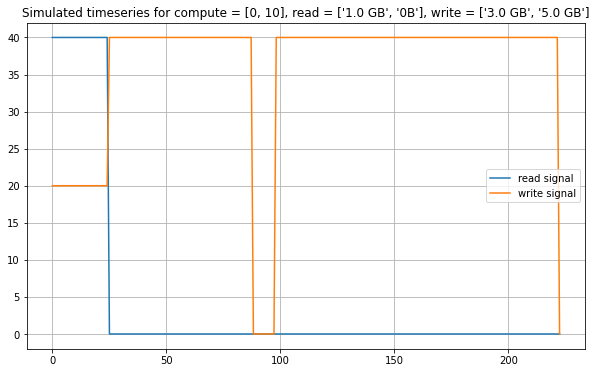

In [2]:
# sim env an data
env = simpy.Environment()
data = simpy.Store(env)
# tier perfs
nvram_bandwidth = {'read':  {'seq': 800, 'rand': 600},
                        'write': {'seq': 400, 'rand': 400}}
ssd_bandwidth = {'read':  {'seq': 240, 'rand': 180},
                    'write': {'seq': 100, 'rand': 100}}
hdd_bandwidth = {'read':  {'seq': 80, 'rand': 80},
                    'write': {'seq': 40, 'rand': 40}}

# registering Tiers
hdd_tier = Tier(env, 'HDD', max_bandwidth=hdd_bandwidth, capacity=1e12)
ssd_tier = Tier(env, 'SSD', max_bandwidth=ssd_bandwidth, capacity=200e9)
nvram_tier = Tier(env, 'NVRAM', max_bandwidth=nvram_bandwidth,
                        capacity=10e9)
# registering Ephemeral Tier
bb = EphemeralTier(env, name="BB", persistent_tier=hdd_tier,
                        max_bandwidth=nvram_bandwidth, capacity=10e9)

# Define the cluster with 1 persistent and 1 ephemeral
cluster = Cluster(env, tiers=[hdd_tier], ephemeral_tier=bb)
jobid=0
# logger
#env = simpy.Environment()
logger.remove()
# Simple app: read 1GB -> compute 10s -> write 5GB
# placement
placement = [0, 0]
use_bb = [False, False]
compute=[0, 10]
read=[1e9, 0]
write=[3e9, 5e9]
# simulate the app execution
app1 = Application(env, compute=compute, read=read, write=write, data=data)
#app2 = Application(env, compute=[0, 5],  read=[2e9, 0], write=[7e9, 0], data=data)
env.process(app1.run(cluster, placement=placement, use_bb=use_bb))
#env.process(app2.run(cluster, placement=placement, use_bb=use_bb))
env.run()
print(f"application duration = {app1.get_fitness()}")

output = get_execution_signal_3(data)

sim_time = np.array(output[app1.name]["time"])
sim_read_bw = np.array(output[app1.name]["read_bw"])
sim_write_bw = np.array(output[app1.name]["write_bw"])

fig = plt.figure(figsize=(10, 6))
plt.plot(sim_time, sim_read_bw, label="read signal")
plt.plot(sim_time, sim_write_bw, label="write signal")
plt.grid(True)
plt.legend()
plt.title(f"Simulated timeseries for compute = {compute}, read = {list(map(convert_size, read))}, write = {list(map(convert_size, write))}")
plt.show()

#### New way to simulate

In [3]:
import yaml, simpy
# sim env an data
env = simpy.Environment()
data = simpy.Store(env)
# tier perfs
cluster_config = """
defaults:
  compute_nodes: 1
  cores_per_node: 2

tiers:
  - name: tier1
    capacity: 100.e+9
    max_bandwidth:
      read:
        seq: 200
        rand: 100
      write:
        seq: 100
        rand: 50

  - name: tier2
    capacity: 500.e+9
    max_bandwidth:
      read:
        seq: 500
        rand: 300
      write:
        seq: 200
        rand: 150

  - name: lfs
    capacity: 500.e+9
    bandwidth_model_path: gradient_boosting_regressor_lfs_bw.joblib

ephemeral_tier:
  name: ephemeral
  persistent_tier: tier1
  capacity: 1.e+9
  max_bandwidth:
    read:
      seq: 500
      rand: 300
    write:
      seq: 200
      rand: 150
"""

cluster = Cluster(env, config_path=cluster_config)
#print(cluster)
print(cluster.tiers[2].bandwidth_model_path)
print(cluster)

gradient_boosting_regressor_lfs_bw.joblib
Cluster with 1 compute nodes 
Each having 2 cores in total 

-------------------
Tier:(Tier) tier1 with capacity = 100.0 GB
Operation    Pattern      Bandwidth MB/s
read         seq          200         
read         rand         100         
write        seq          100         
write        rand         50          

-------------------
Tier:(Tier) tier2 with capacity = 500.0 GB
Operation    Pattern      Bandwidth MB/s
read         seq          500         
read         rand         300         
write        seq          200         
write        rand         150         

-------------------
Tier:(Tier) lfs with capacity = 500.0 GB
Operation    Pattern      Bandwidth MB/s
Bandwidth model path: gradient_boosting_regressor_lfs_bw.joblib

-------------------
Tier:(EphemeralTier) ephemeral with capacity = 1.0 GB
Operation    Pattern      Bandwidth MB/s
read         seq          500         
read         rand         300         
write        se

In [4]:
new_data = pd.DataFrame({
            'nodes': [1, 1],
            'read_io_size': [8e6, 6e6],
            'write_io_size': [8e6, 6e6],
            'read_volume': [169e6, 200e6],
            'write_volume': [330e6, 200e6],
            'read_io_pattern': ['stride', 'seq'],
            'write_io_pattern': ['stride', 'seq'],
        })
bw = cluster.tiers[2].get_max_bandwidth(new_data=new_data)
# expects 503 MB/s (lfs) and 1GB/s (fs1)
print(bw)

[1.44045460e+09 2.78949499e+09]


#### Real IOI Job, getting representation and phase features

In [9]:
jobid=3918
dataset_path = os.path.join(dirname(dirname(os.getcwd())), "performance_data", "performance_data", "dataset")
#%%capture
logger.remove()
def decompose_ioi_job(jobid):
    with patch.object(ComplexDecomposer, 'get_job_timeseries') as mock_get_timeseries:
        with patch.object(Configuration, 'get_kc_token') as mock_get_kc_token:
            with patch.object(ComplexDecomposer, 'get_job_node_count') as mock_get_node_count:
                mock_get_timeseries.return_value = get_job_timeseries_from_file(job_id=jobid)
                mock_get_kc_token.return_value = 'token'
                mock_get_node_count.return_value = 1
                # init the job decomposer
                #cd = ComplexDecomposer(v0_threshold=0.02)
                cd = ComplexDecomposer(v0_threshold=0.01)
                return cd
# Launch decomposition on the signal
cd = decompose_ioi_job(jobid=jobid)
# Showing representation
representation = cd.get_job_representation(merge_clusters=True)
pprint(representation)
phases_features = pd.DataFrame(cd.get_phases_features(representation))
pprint(phases_features)

%time bw = cluster.tiers[2].get_max_bandwidth(new_data=pd.DataFrame(phases_features))
pprint(type(bw))
pprint(bw)

{'events': [0, 1, 8, 12, 44, 50, 54, 56],
 'node_count': 1,
 'read_bw': [0,
             1730808132.0,
             794387563.0,
             1584492138.5,
             3023280.0,
             3527160.0,
             2519400.0,
             0],
 'read_operations': [0, 812, 1305, 909, 601, 1400, 500, 0],
 'read_pattern': ['Uncl', 'Seq', 'Seq', 'Seq', 'Seq', 'Seq', 'Seq', 'Uncl'],
 'read_volumes': [0,
                  1730808132,
                  1588775126,
                  3168984277,
                  3023280,
                  7054320,
                  2519400,
                  0],
 'write_bw': [0,
              0,
              1019392798.5,
              1379672406.0,
              1333699712.25,
              1326288590.25,
              1066959769.8,
              0],
 'write_operations': [0, 0, 986, 2000, 1000, 995, 1000, 0],
 'write_pattern': ['Uncl', 'Uncl', 'Seq', 'Seq', 'Seq', 'Seq', 'Seq', 'Uncl'],
 'write_volumes': [0,
                   0,
                   20387855

In [6]:
new_data.head()

,nodes,read_io_size,write_io_size,read_volume,write_volume,read_io_pattern,write_io_pattern
0,1,8000000.0,8000000.0,169000000.0,330000000.0,stride,stride
1,1,6000000.0,6000000.0,200000000.0,200000000.0,seq,seq


In [1]:
import pandas as pd
from cluster_simulator.phase import PhaseFeatures

pf = PhaseFeatures(cores=1, read_io_size=8e6, write_io_size=8e6, read_volume=int(169e6), write_volume=int(330e6), read_io_pattern='stride', write_io_pattern='seq')

df = pd.DataFrame(pf.get_attributes()) 
df.head()

,cores,read_io_size,write_io_size,read_volume,write_volume,read_io_pattern,write_io_pattern
0,2,8000000.0,8000000.0,169000000,330000000,stride,seq


In [ ]:
%time print(load_and_predict("/home_nfs/mimounis/iosea-wp3-recommandation-system/performance_data/performance_data/notebooks/random_forest_regressor_fs1_bw.joblib", new_data=pd.DataFrame(phases_features), iops=True))

%time print(load_and_predict("/home_nfs/mimounis/iosea-wp3-recommandation-system/performance_data/performance_data/notebooks/decision_tree_regressor_lfs_bw.joblib", new_data=pd.DataFrame(phases_features), iops=True))

#### Replaying the job

In [20]:

# tier perfs
cluster_config = """
defaults:
  compute_nodes: 1
  cores_per_node: 2

tiers:
  - name: tier1
    capacity: 100.e+9
    max_bandwidth:
      read:
        seq: 200
        rand: 100
      write:
        seq: 100
        rand: 50

  - name: tier2
    capacity: 500.e+9
    max_bandwidth:
      read:
        seq: 500
        rand: 300
      write:
        seq: 200
        rand: 150

  - name: lfs
    capacity: 500.e+9
    bandwidth_model_path: gradient_boosting_regressor_lfs_bw.joblib

ephemeral_tier:
  name: ephemeral
  persistent_tier: tier1
  capacity: 1.e+9
  max_bandwidth:
    read:
      seq: 500
      rand: 300
    write:
      seq: 200
      rand: 150
"""
env = simpy.Environment()
data = simpy.Store(env)
cluster = Cluster(env, config_path=cluster_config)

In [23]:
bw_normed = (bw/1e6).tolist()
app1 = Application(env, name=f"StaticTier#{jobid}",                  
                    compute=representation["events"],
                    read=representation["read_volumes"],
                    write=representation["write_volumes"],
                    #read_bw=bw_normed, write_bw=bw_normed, 
                    data=data)

app2 = Application(env, name=f"PerfTier#{jobid}",                  
                    compute=representation["events"],
                    read=representation["read_volumes"],
                    write=representation["write_volumes"],
                    #read_bw=bw_normed, write_bw=bw_normed, 
                    data=data)
env.process(app1.run(cluster, placement=[2]*(len(representation["events"]))))
#env.process(app2.run(cluster, placement=[1]*(len(representation["events"]))))
env.run()
fig = display_apps_dataflow(data, cluster, width=800, height=600)
fig.show()

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [ ]:
fig = display_run(data, cluster, width=800, height=900)
fig.show()
output = get_execution_signal_3(data, nbr_points=len(cd.timestamps))
sim_time = np.array(output[app.name]["time"])
sim_read_bw = np.array(output[app.name]["read_bw"])
sim_write_bw = np.array(output[app.name]["write_bw"])


In [ ]:
env = simpy.Environment()
data = simpy.Store(env)
cluster = Cluster(env, config_path=cluster_config)
bw_normed = (bw/1e6).tolist()
app = Application(env, name=f"PerfTier#{jobid}",                  
                    compute=representation["events"],
                    read=representation["read_volumes"],
                    write=representation["write_volumes"],
                    read_bw=bw_normed, write_bw=bw_normed, 
                    data=data)
env.process(app.run(cluster, placement=[1]*(len(representation["events"]))))
env.run()
fig = display_apps_dataflow(data, cluster, width=800, height=400)
fig.show()
print(representation["events"])
output = get_execution_signal_3(data, nbr_points=len(cd.timestamps))
sim_time = np.array(output[app.name]["time"])
sim_read_bw = np.array(output[app.name]["read_bw"])
sim_write_bw = np.array(output[app.name]["write_bw"])
plot_detected_phases(jobid, merge=True, show_phases=False, 
                     ts=(sim_time, sim_read_bw, sim_write_bw), 
                     width=800, height=400)